In [1]:
# Dependencies and Setup
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests
import time
import datetime as dt
from scipy.stats import linregress
import random
from pprint import pprint
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [2]:
#collecting historical data to train and predict future stock prices
import requests
import json 
key = '71H6VN2GGMWU3MAU'
ticker = 'CVS'
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}'.format(ticker, key)
time_series = requests.get(url)
print(time_series.json())

{'Meta Data': {'1. Information': 'Daily Time Series with Splits and Dividend Events', '2. Symbol': 'CVS', '3. Last Refreshed': '2020-11-09', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2020-11-09': {'1. open': '69.0000', '2. high': '69.6300', '3. low': '65.7750', '4. close': '67.5300', '5. adjusted close': '67.5300', '6. volume': '15696356', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}, '2020-11-06': {'1. open': '63.0500', '2. high': '67.3300', '3. low': '63.0200', '4. close': '64.9500', '5. adjusted close': '64.9500', '6. volume': '24526887', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}, '2020-11-05': {'1. open': '61.3600', '2. high': '62.6104', '3. low': '61.0300', '4. close': '61.4100', '5. adjusted close': '61.4100', '6. volume': '10069433', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}, '2020-11-04': {'1. open': '61.2500', '2. high': '61.9600', '3. low': '60.2250', '4. close': '60.3700', 

In [3]:
# Pretty print JSON for a specific launchpad
time_series = requests.get(url + "Meta Data").json()
print(json.dumps(time_series, indent=4, sort_keys=True))

{
    "Meta Data": {
        "1. Information": "Daily Time Series with Splits and Dividend Events",
        "2. Symbol": "CVS",
        "3. Last Refreshed": "2020-11-09",
        "4. Output Size": "Compact",
        "5. Time Zone": "US/Eastern"
    },
    "Time Series (Daily)": {
        "2020-06-19": {
            "1. open": "65.9100",
            "2. high": "66.0000",
            "3. low": "64.1100",
            "4. close": "64.4900",
            "5. adjusted close": "63.4527",
            "6. volume": "21245639",
            "7. dividend amount": "0.0000",
            "8. split coefficient": "1.0"
        },
        "2020-06-22": {
            "1. open": "64.5400",
            "2. high": "64.7300",
            "3. low": "63.2800",
            "4. close": "64.3000",
            "5. adjusted close": "63.2658",
            "6. volume": "6063210",
            "7. dividend amount": "0.0000",
            "8. split coefficient": "1.0"
        },
        "2020-06-23": {
            "1. open

In [4]:
pd.set_option('display.max_columns', None)
time_series_df = pd.DataFrame(time_series["Time Series (Daily)"])
CVS = time_series_df.transpose()
CVS.head(100)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-11-09,69.0000,69.6300,65.7750,67.5300,67.5300,15696356,0.0000,1.0
2020-11-06,63.0500,67.3300,63.0200,64.9500,64.9500,24526887,0.0000,1.0
2020-11-05,61.3600,62.6104,61.0300,61.4100,61.4100,10069433,0.0000,1.0
2020-11-04,61.2500,61.9600,60.2250,60.3700,60.3700,11190785,0.0000,1.0
2020-11-03,58.4600,60.0800,58.4000,59.4500,59.4500,7153941,0.0000,1.0
...,...,...,...,...,...,...,...,...
2020-06-25,62.7000,64.2000,62.4200,64.0200,62.9903,5680858,0.0000,1.0
2020-06-24,63.8100,64.0500,62.3300,63.1800,62.1638,7161119,0.0000,1.0
2020-06-23,64.8600,65.2600,64.3300,64.4300,63.3937,5259584,0.0000,1.0
2020-06-22,64.5400,64.7300,63.2800,64.3000,63.2658,6063210,0.0000,1.0


In [5]:
cvs_df = CVS.rename(columns={"1. open":"open",
                            "2. high": "high",
                            "3. low": "low",
                            "4. close":"close",
                            "5. adjusted close": "adjusted close",
                            "6. volume": "volume",
                            "7. dividend amount": "dividend amount",
                            "8. split coefficient": "split coefficent"})
cvs_df

,open,high,low,close,adjusted close,volume,dividend amount,split coefficent
2020-11-09,69.0000,69.6300,65.7750,67.5300,67.5300,15696356,0.0000,1.0
2020-11-06,63.0500,67.3300,63.0200,64.9500,64.9500,24526887,0.0000,1.0
2020-11-05,61.3600,62.6104,61.0300,61.4100,61.4100,10069433,0.0000,1.0
2020-11-04,61.2500,61.9600,60.2250,60.3700,60.3700,11190785,0.0000,1.0
2020-11-03,58.4600,60.0800,58.4000,59.4500,59.4500,7153941,0.0000,1.0
...,...,...,...,...,...,...,...,...
2020-06-25,62.7000,64.2000,62.4200,64.0200,62.9903,5680858,0.0000,1.0
2020-06-24,63.8100,64.0500,62.3300,63.1800,62.1638,7161119,0.0000,1.0
2020-06-23,64.8600,65.2600,64.3300,64.4300,63.3937,5259584,0.0000,1.0
2020-06-22,64.5400,64.7300,63.2800,64.3000,63.2658,6063210,0.0000,1.0


In [6]:
cvs_df.isna().any()

open                False
high                False
low                 False
close               False
adjusted close      False
volume              False
dividend amount     False
split coefficent    False
dtype: bool

In [7]:
cvs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 2020-11-09 to 2020-06-19
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   open              100 non-null    object
 1   high              100 non-null    object
 2   low               100 non-null    object
 3   close             100 non-null    object
 4   adjusted close    100 non-null    object
 5   volume            100 non-null    object
 6   dividend amount   100 non-null    object
 7   split coefficent  100 non-null    object
dtypes: object(8)
memory usage: 7.0+ KB


In [8]:
cvs_df["open"] = cvs_df["open"].astype(float)
cvs_df["high"] = cvs_df["high"].astype(float)
cvs_df["low"] = cvs_df["low"].astype(float)
cvs_df["close"] = cvs_df["close"].astype(float)
cvs_df["adjusted close"] = cvs_df["adjusted close"].astype(float)
cvs_df["volume"] = cvs_df["volume"].astype(float)
cvs_df["dividend amount"] = cvs_df["dividend amount"].astype(float)
cvs_df["split coefficent"] = cvs_df["split coefficent"]. astype(float)
cvs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 2020-11-09 to 2020-06-19
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              100 non-null    float64
 1   high              100 non-null    float64
 2   low               100 non-null    float64
 3   close             100 non-null    float64
 4   adjusted close    100 non-null    float64
 5   volume            100 non-null    float64
 6   dividend amount   100 non-null    float64
 7   split coefficent  100 non-null    float64
dtypes: float64(8)
memory usage: 7.0+ KB


In [9]:
cvs_df.to_csv("Output/CVS.csv", index=False, header=True)

In [16]:
# 7 day average price
cvs_df.rolling(7).mean().head(50)

,open,high,low,close,adjusted close,volume,dividend amount,split coefficent
2020-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-30,60.845714,62.306486,60.005671,61.125714,61.125714,1.239155e+07,0.000000,1.0
2020-10-29,59.054286,60.455057,58.517814,59.468571,59.468571,1.154321e+07,0.000000,1.0
2020-10-28,58.241429,59.113629,57.577814,58.271429,58.271429,9.562254e+06,0.000000,1.0
2020-10-27,57.921429,58.635571,57.160671,57.805714,57.805714,8.897338e+06,0.000000,1.0


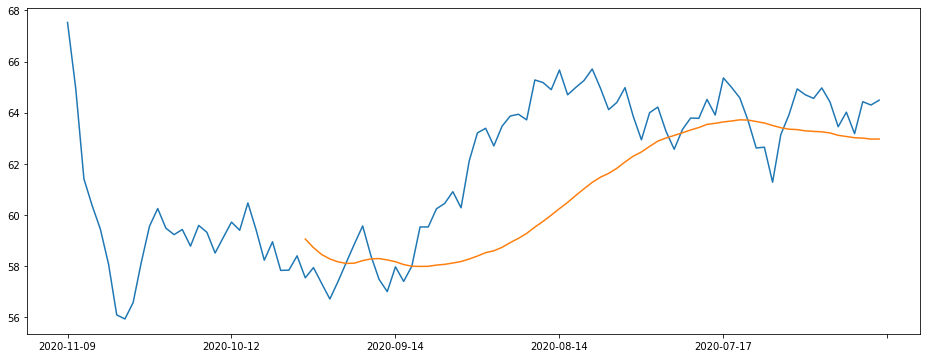

In [21]:
#average cost price vs adjusted close 
cvs_df["close"].plot(figsize=(16,6))
cvs_df.rolling(window=30).mean()["adjusted close"].plot()

In [22]:
#data preprocessing
#training data set
training_set = cvs_df["adjusted close"]
training_set = pd.DataFrame(training_set)

In [23]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform (training_set)
scaled_data

array([[1.        ],
       [0.77758621],
       [0.47241379],
       [0.38275862],
       [0.30344828],
       [0.18534483],
       [0.0137931 ],
       [0.        ],
       [0.05517241],
       [0.19137931],
       [0.31293103],
       [0.37241379],
       [0.30603448],
       [0.28448276],
       [0.25883621],
       [0.20327586],
       [0.27251724],
       [0.24943103],
       [0.18018966],
       [0.23233621],
       [0.28362931],
       [0.25627586],
       [0.34774138],
       [0.25798276],
       [0.15625862],
       [0.21780172],
       [0.12206034],
       [0.12291379],
       [0.17078448],
       [0.09726724],
       [0.13146552],
       [0.07846552],
       [0.02631897],
       [0.08530172],
       [0.14856034],
       [0.21096552],
       [0.27080172],
       [0.17163793],
       [0.09213793],
       [0.05111207],
       [0.13402586],
       [0.08530172],
       [0.13659483],
       [0.26738793],
       [0.26738793],
       [0.32807759],
       [0.34603448],
       [0.385

In [26]:
#spilt data into x_train and y_training sets 
# training data from Day 1 to Day 60 and make predictions from 61 forward 
# then train data from Day 2 to Day 61 and make predictions from 62 forward
# range up to 100
x_train = []
y_train = []
#append the last 60 values
for i in range (60,100):
  x_train.append(scaled_data[i-60:i, 0])
  y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

#reshaping the trained data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
#feature extraction ("open","adjusted close","volume")
#RNN initiation #LSTM model
import keras.layers import Dropout 
model = Sequential()
#first layer 
model.add(LSTM( 50, return_sequences=True, input_shape= (x_train.shape[1], 1)))

model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))